# Code used in Meisler, Gabrieli, and Christodoulou 202X

In [29]:
# Import packages
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import pingouin as pg
import scipy.stats as st
import seaborn as sns
from sklearn import preprocessing
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

# Define tracts of interest with their dataframe column names and full names
tracts = {'Left_AF':'Left AF',
          'Right_AF':'Right AF',
          'Latscore_AF':'Laterality Index AF',
          'Left_ILF':'Left ILF',
          'Right_ILF':'Right ILF',
          'Latscore_ILF':'Laterality Index ILF',
          'Left_CST':'Left CST',
          'Right_CST':'Right CST',
          'Latscore_CST':'Laterality Index CST',
          'Splenium':'Splenium'}


## Load in Dataframe

In [30]:
#df = pd.read_csv('df_share.csv') # This is the DF from the repo
df = pd.read_csv('df.csv') # This is the DF from the repo
df = df.set_index('subjects')
df['All']=['All' for i in range(len(df))]

## Rescale data (z-score continuous columns)

In [31]:
# Don't try to rescale binary columns
keys_to_not_standardize = ['Sex','Handedness','Intervention','ADHD','All',
                           'SIT_raw_responder', 'SIT_ss_responder',
                          'Composite_Score_raw_responder', 'Composite_Score_ss_responder']
keys_to_standardize = [key for key in df.keys() if key not in keys_to_not_standardize]
df_std = df[keys_to_not_standardize]
for key in keys_to_standardize:
    df_std[key] = preprocessing.scale(df[key], with_mean=True, with_std=True)
    
# Get separate dataframes for intervention and no intervention
df_int = df_std[df_std['Intervention']=='Y']
df_no_int = df_std[df_std['Intervention']=='N']

## Print out group summary stats (Table 1)

In [ ]:
# t-tests
for key in ['Age_pre','SES', 'SWE2_ss_pre', 'SWE2_ss_post', 'PDE2_ss_pre', 'PDE2_ss_post', 
            'W3WI_ss_pre', 'W3WI_ss_post', 'W3WA_ss_pre', 'W3WA_ss_post', 'SIT_ss_pre', 'SIT_ss_post', 'SIT_ss_diff',
           'Composite_Score_ss_pre', 'Composite_Score_ss_post', 'Composite_Score_ss_diff', 'KBIT2Mss',
           'wholebrain_MD_pre', 'wholebrain_MD_post', 'wholebrain_MD_diff', 'wholebrain_FA_pre', 'wholebrain_FA_post',
           'wholebrain_FA_diff']:
    
    print(key)
    stat_grouped = df.groupby('Intervention')[key].agg(['mean', 'sem'])
    stat_all = df.groupby('All')[key].agg(['mean', 'sem'])
    stat_combined = pd.concat([stat_all,stat_grouped])
    stat_ints = df[key][df['Intervention']=='Y']
    stat_no_ints = df[key][df['Intervention']=='N']
    group_comparison = pg.ttest(stat_ints, stat_no_ints)
    print(stat_combined,'\n',group_comparison,'\n')

## Run Models (Table 2+3 and Supplemental Figures S1,S3,S4)

+----------------------+-------------------------+---------------+------------------+----------------+---------+-------------+
| Tract                | Test Type               |   Coefficient | 95% CI           |   delta_r2_adj |   p_val |   p_val_fdr |
+======================+=========================+===============+==================+================+=========+=============+
| White Matter Average | SIT                     |        -0.195 | (-0.558, 0.168)  |          0.005 |   0.282 |       0.438 |
+----------------------+-------------------------+---------------+------------------+----------------+---------+-------------+
| Left AF              | SIT                     |        -0.259 | (-0.533, 0.015)  |          0.04  |   0.063 |       0.172 |
+----------------------+-------------------------+---------------+------------------+----------------+---------+-------------+
| Right AF             | SIT                     |         0.177 | (-0.137, 0.492)  |          0.006 |   0.26  

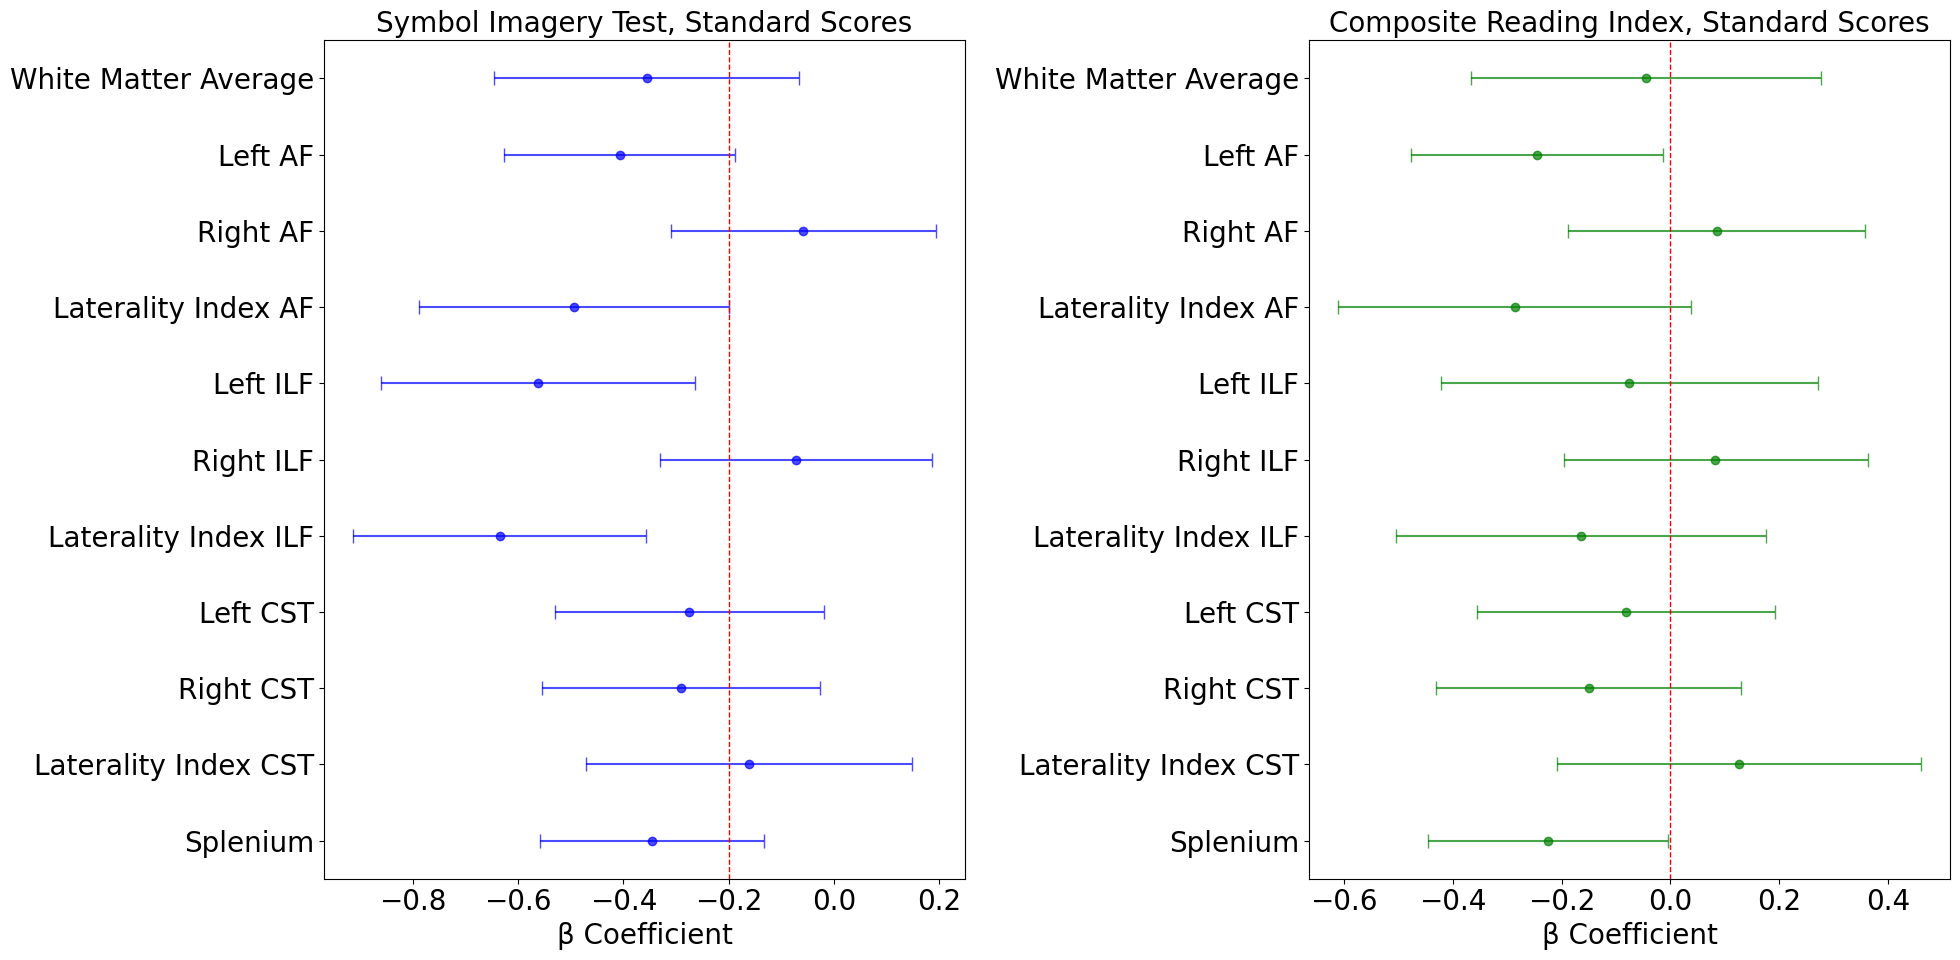

In [32]:
# Parameters of analysis, change these as needed
metric = "MD" # FA, MD, RD, or AD
session = 'diff' # 'pre', 'post', or 'diff'
scoretype = 'ss' # 'ss' for standard score, 'raw' for raw score
tests = ['SIT', 'Composite_Score']
data = df_std # df_std for all subjects with z-scoring, df for all subjects without standardization, 
              # df_int for just intervention, df_no_int for just no intervention
include_whitematter_covaraiate = False # Include white matter covariate in model
                                      # (ignored for AD models, RD models, white matter models, and laterality index models)
additional_covariates = [] # Covariates not used in primary analyses, e.g., "Group", "Handedness", if you want to explore
if len(additional_covariates) > 0:
    additional_covariates_string = ' + ' + ' + '.join(additional_covariates)
else:
    additional_covariates_string = ''
fig_name = f"Betas_{scoretype}_{session}_{metric}_all" # Output name for figure
verbose = False # True to print summaries for each model

# Initialize some output variables for plotting later
p_vals = []
p_vals_fdr = []
intervals_95_high = []
intervals_95_low = []
coefs = []
delta_r2_adjs = []
tracts_to_plot = []

for test in tests:
    p_vals_test = []
    
    # Only include white matter averaged metric if doing MD or FA
    if metric == 'RD' or metric == 'AD':
        # No white matter average for these metrics
        tract_loop = zip(list(tracts.keys()), list(tracts.values()))
    else:
        # Include white matter average
        tract_loop = zip(['wholebrain'] + list(tracts.keys()), ["White Matter Average"] + list(tracts.values()))
        
    for tract,desc in tract_loop:
        ### Define the model formula
        formula_base = f"{tract}_{metric}_{session} ~ Sex"
        # If looking at difference, add age at first scan and both TMI time points
        if session == 'diff':
            formula_reduced = formula_base + ' + Age_pre + TMI_pre + TMI_post' + additional_covariates_string # + Group or Handedness?
        # Otherwise, for cross-sectional data add Age and TMI for that given time point
        else:
            formula_reduced = formula_base + f' + Age_{session} + TMI_{session}'

        if include_whitematter_covaraiate and "Latscore" not in tract and "wholebrain" not in tract and metric != 'RD' and metric != 'AD':
            formula_reduced += f" + wholebrain_{metric}_{session}"

        # Add the predictor of interest (reading measure) as last term
        formula_full = formula_reduced + f" + {test}_{scoretype}_{session}"

        # Run the full model
        model_full = smf.ols(formula=formula_full, data=data).fit()
        r2_full = model_full.rsquared_adj
        # Run the reduced model
        model_reduced = smf.ols(formula=formula_reduced, data=data).fit()
        r2_reduced = model_reduced.rsquared_adj
        # Get effect size
        r2_diff = r2_full - r2_reduced
        delta_r2_adjs.append(r2_diff)
        
        # Print each model summary if verbose reporting is on
        if verbose:
            print('\n'+tract, 'FORMULA:',formula_full)
            print('\n R2-adj for Reading Term:',r2_diff,'\n')
            print(model_full.summary())

        ### Get model parameters just about the predictor of interest
        # Get p-value from model_full
        p_val = model_full.pvalues[f'{test}_{scoretype}_{session}']
        # Get Coefficient and 95% CI limits
        data_table = model_full.summary().tables[1].data
        interval_95_low = float(data_table[-1][-2])
        interval_95_high = float(data_table[-1][-1])
        coef = float(data_table[-1][1])
        # Save results for plotting later
        p_vals_test.append(p_val)
        intervals_95_low.append(interval_95_low)
        intervals_95_high.append(interval_95_high)
        coefs.append(coef)
        tracts_to_plot.append(desc)
    
    ### FDR Correct
    p_vals.extend(p_vals_test) # Save out uncorrected p-values
    p_vals_test_fdr = statsmodels.stats.multitest.multipletests(p_vals_test, method='fdr_bh')[1]
    p_vals_fdr.extend(p_vals_test_fdr) # Save out FDR-corrected p-values

### Print out summary table
# Create a list to store rows of the table
table_rows = []
num_tests=len(p_vals)

# First half of the data (SIT score tests)
for tract, p_val, p_val_fdr, delta_r2_adj, coef, interval_95_low, interval_95_high in zip(tracts_to_plot, p_vals[:num_tests//2],
                                                       p_vals_fdr[:num_tests//2], delta_r2_adjs[:num_tests//2],
                                                       coefs[:num_tests//2], intervals_95_low[:num_tests//2],
                                                       intervals_95_high[:num_tests//2]):
    table_rows.append([tract, 'SIT', "{:.3f}".format(coef), f"({interval_95_low:.3f}, {interval_95_high:.3f})",
                       "{:.3f}".format(delta_r2_adj), "{:.3f}".format(p_val), "{:.3f}".format(p_val_fdr)])

# Second half of the data (Composite score tests)
for tract, p_val, p_val_fdr, delta_r2_adj, coef, interval_95_low, interval_95_high in zip(tracts_to_plot, p_vals[num_tests//2:],
                                                        p_vals_fdr[num_tests//2:], delta_r2_adjs[num_tests//2:],
                                                        coefs[num_tests//2:], intervals_95_low[num_tests//2:],
                                                        intervals_95_high[num_tests//2:]):
    table_rows.append([tract, 'Composite Reading Index', "{:.3f}".format(coef), f"({interval_95_low:.3f}, {interval_95_high:.3f})",
                       "{:.3f}".format(delta_r2_adj), "{:.3f}".format(p_val), "{:.3f}".format(p_val_fdr)])

# Headers for the table
headers = ['Tract', 'Test Type', 'Coefficient', '95% CI', 'delta_r2_adj', 'p_val', 'p_val_fdr']

# Print the table
print(tabulate(table_rows, headers=headers, tablefmt='grid'))

### Make coefficient plot
fontsize = 20
# Create a horizontal bar plot
errors_low = [a - b for a, b in zip(coefs, intervals_95_low)]
errors_high = [a - b for a, b in zip(intervals_95_high , coefs)] 

# Split the data into two halves
half_length = len(coefs) // 2

# Reverse the order for both halves for plotting purposes
coefs_first_half = coefs[:half_length][::-1]
errors_low_first_half = errors_low[:half_length][::-1]
errors_high_first_half = errors_high[:half_length][::-1]

coefs_second_half = coefs[half_length:][::-1]
errors_low_second_half = errors_low[half_length:][::-1]
errors_high_second_half = errors_high[half_length:][::-1]

# Create two subplots for the first and second halves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

tracts_to_plot = tracts_to_plot[:len(tracts_to_plot)//2][::-1]

# Plot for the first half
ax1.errorbar(coefs_first_half, range(1, half_length + 1), xerr=[errors_low_first_half, errors_high_first_half], fmt='o', color='blue', alpha=0.7, capsize=5)
ax1.axvline(x=0, linestyle='--', color='red', linewidth=1)
ax1.set_yticks(range(1, half_length + 1))
ax1.set_yticklabels(tracts_to_plot, fontsize=fontsize)
ax1.set_xlabel('β Coefficient', fontsize=fontsize)
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=fontsize)
ax1.set_title('Symbol Imagery Test, Standard Scores', fontsize=fontsize)

# Plot for the second half
ax2.errorbar(coefs_second_half, range(1, half_length + 1), xerr=[errors_low_second_half, errors_high_second_half], fmt='o', color='green', alpha=0.7, capsize=5)
ax2.axvline(x=0, linestyle='--', color='red', linewidth=1)
ax2.set_yticks(range(1, half_length + 1))
ax2.set_yticklabels(tracts_to_plot, fontsize=fontsize)
ax2.set_xlabel('β Coefficient', fontsize=fontsize)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=fontsize)
ax2.set_title('Composite Reading Index, Standard Scores', fontsize=fontsize)

plt.tight_layout()
#plt.savefig(f'figures/{fig_name}.png', dpi=300)
plt.show()

## Regression Plots (Figure 3)

eval_env: 1


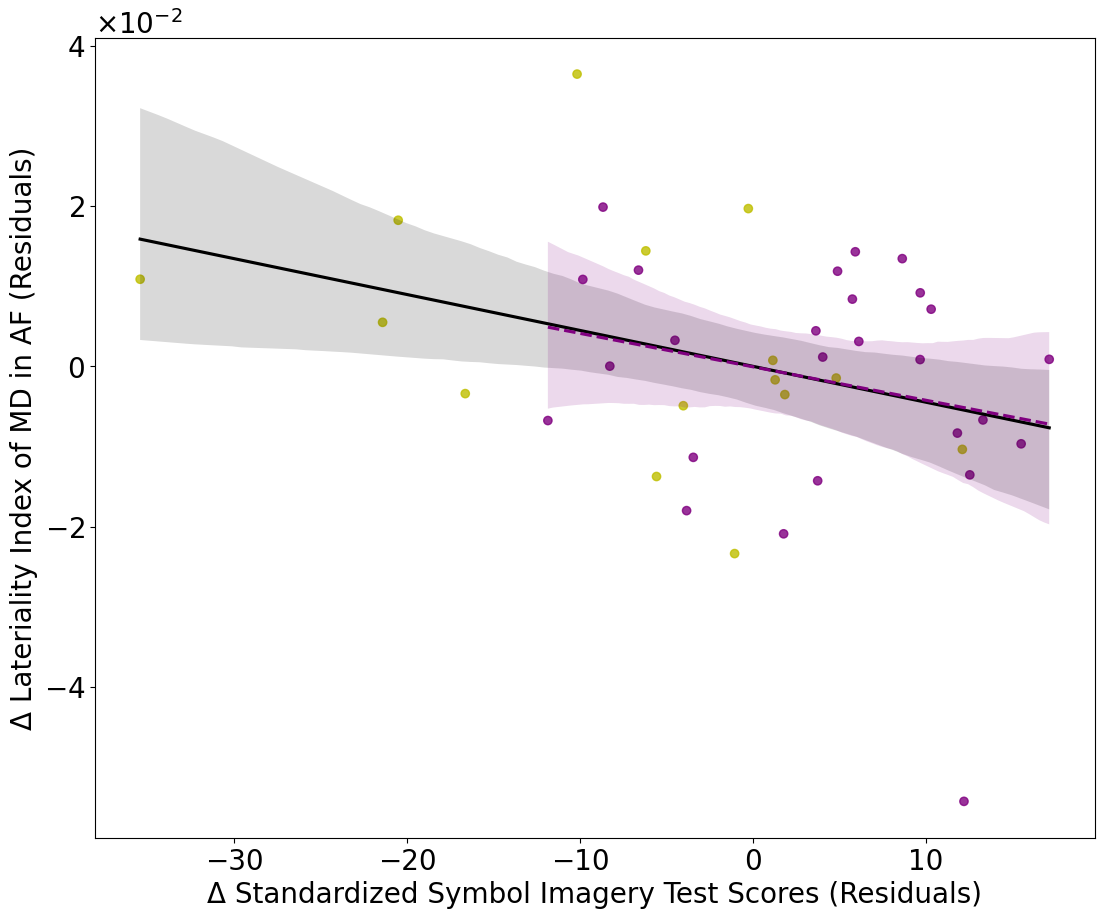

In [10]:
fig_frame = plt.figure(figsize=(10, 8))
ax=fig_frame.add_axes([0,0,1,1])
data = df # df_std for all subjects with z-scoring, df for all subjects without standardization, 
                  # df_int for just intervention, df_no_int for just no intervention
hemi = 'Latscore' # 'Left', 'Right', or "Latscore
tract = 'AF' # 'Left_AF', 'Right_AF', 'Left_ILF', 'Right_ILF', 'Left_CST', 'Right_CST', 'Splenium'
metric = 'MD' # 'MD' or 'FA'
session = 'diff' # 'pre', 'post', or 'diff'
test = 'SIT' # 'Composite_Score', 'SIT', or other reading scores of interest
scoretype = 'ss' # 'ss' for standard score, 'raw' for raw score
int_color = 'purple' # color for intervention group
no_int_color = 'y' # color for no intervention group

int_line = True
rcParams.update({'font.size': 20})

if session == 'diff':
    covars = ['Sex', 'Age_pre', 'TMI_pre', 'TMI_post']
else:
    covars = ['Sex', f'Age_{session}', f'TMI_{session}']

labels = df['Intervention']
intervention_inds = (labels=='Y')

colors = [int_color if group=='Y' else no_int_color for group in labels]

if tract != 'Splenium':
    endog_label = f'{hemi}_{tract}_{metric}_{session}'
else:
    endog_label = f'{tract}_{metric}_{session}' # no hemi label for splenium
    
    
fig, coords = statsmodels.graphics.regressionplots.plot_partregress(endog=f'{endog_label}', exog_i=f'{test}_{scoretype}_{session}',
                                                      exog_others = covars, data=data, ax=ax, obs_labels=False, ret_coords=True, marker=None)
x_coords = coords[0]
y_coords = coords[1]

plt.cla()
if metric == 'MD':
    ax.ticklabel_format(axis='y', style='', scilimits=(0,0), useOffset=None, useLocale=None, useMathText=True)
sns.regplot(data=None, x=x_coords, y=y_coords, truncate = True, line_kws={'color':'k','linestyle':'-'}, scatter_kws={'color':colors})
sns.regplot(data=None, x=x_coords[intervention_inds], y=y_coords[intervention_inds], truncate = True, scatter = False, line_kws={'color':int_color,'linestyle':'--'})

if scoretype == 'ss':
    test_label = 'Standardized'
elif scoretype =='raw' :
    test_label += 'Raw'
if test == 'SIT':
    test_label += ' Symbol Imagery Test'
elif test == 'Composite_Score':
    test_label += ' Composite Reading Index'


if session == 'diff':
    xlabel = f'Δ {test_label} Scores (Residuals)'
    if tract != 'Splenium':
        if hemi == 'Latscore':
            ylabel = f'Δ Lateriality Index of {metric} in {tract} (Residuals)'
        else:
            ylabel = f'Δ {metric} in {hemi} {tract} (Residuals)'
    else:
        ylabel = f'Δ {metric} in {tract} (Residuals)'
else:
    xlabel = f'{test_label} Scores at Time {session.capitalize()} (Residuals)'
    if tract != 'Splenium':
        ylabel = f'{metric} in {hemi} {tract} at Time {session.capitalize()} (Residuals)'
    else:
        ylabel = f'{metric} in {tract} at Time {session.capitalize()} (Residuals)'
        

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.savefig(f'figures/{test}_{scoretype}_{session}_{metric}_{hemi}_{tract}.svg')
plt.show()

### Plot changes in SIT scores (Figure 2)

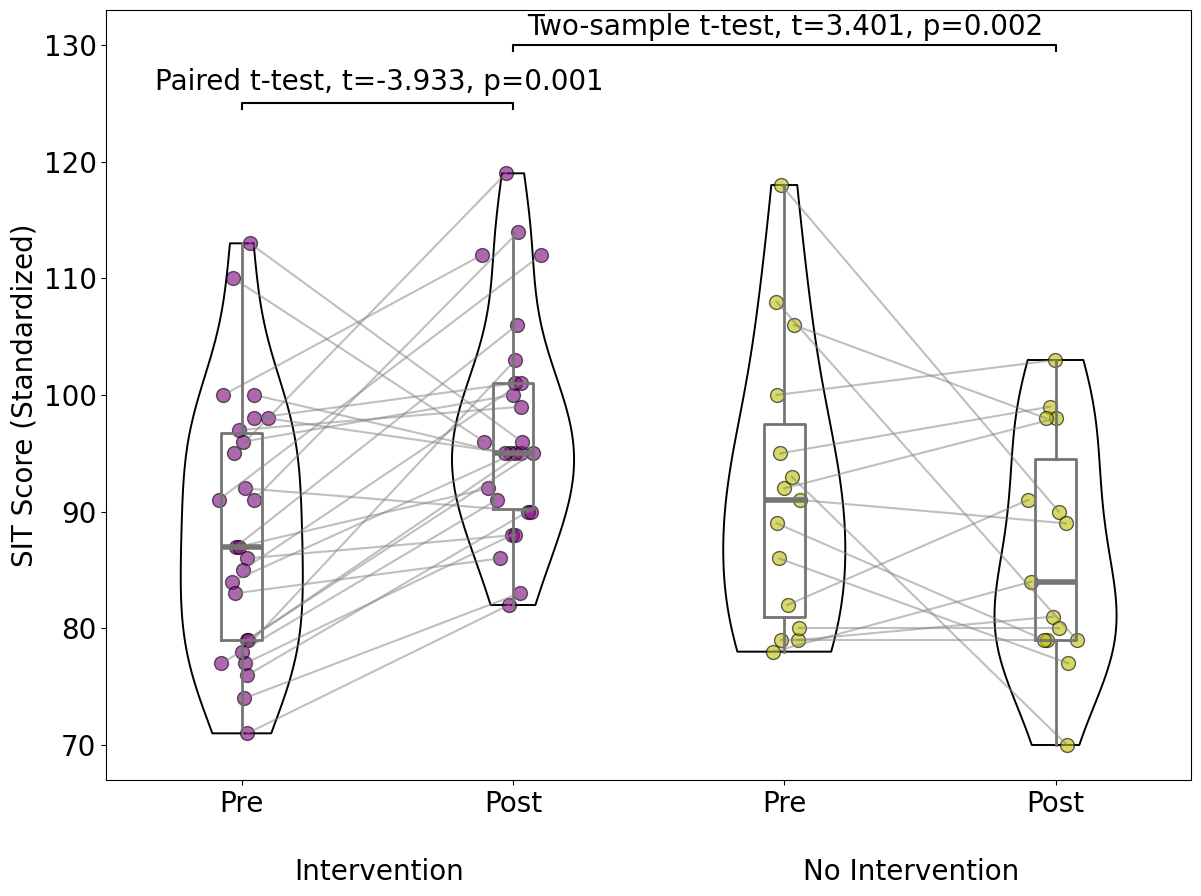

In [16]:
# Create figure/axes object
fig, ax = plt.subplots(figsize= (14, 10))

# Colors for plot
BG_WHITE = "#fbf9f4"
GREY_DARK = "#747473"
# Set background color
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Colors for participant data
COLOR_SCALE = ["purple", "purple", "y", "y"]

tick_len = 0.5 # For signifiance markers

# Horizontal positions for the violins. 
POSITIONS = [0, 1, 2, 3]

# Get reading data to plot for intervention and no intervention groups
times = ['pre', 'post']
score = "SIT_ss"
scores_int = [df[df["Intervention"] == "Y"][f"{score}_{time}"].values for time in times]
scores_noint = [df[df["Intervention"] == "N"][f"{score}_{time}"].values for time in times]

# Define x position of dots with a jitter
jitter = 0.03
x_data_int = [np.array([i] * len(d)) for i, d in enumerate(scores_int)]
x_data_noint = [np.array([i+2] * len(d)) for i, d in enumerate(scores_noint)]
x_jittered_int = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data_int]
x_jittered_noint = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data_noint]

### Add intervention data

# Add violins
violins = ax.violinplot(
    scores_int, 
    positions=POSITIONS[0:2],
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)
# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor("BLACK")
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    
# Add boxplots
medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    scores_int,
    positions=POSITIONS[0:2], 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots
for x, y, color in zip(x_jittered_int, scores_int, COLOR_SCALE[0:2]):
    ax.scatter(x, y, s = 100, color=color, alpha=0.6, edgecolors='k')
# Add lines connecting the pre-post pairs
for i in range(np.shape(x_jittered_int)[1]):
    plt.plot([x_jittered_int[0][i], x_jittered_int[1][i]], [scores_int[0][i], scores_int[1][i]], color='gray', alpha=0.5)
    
### Add no intervention data
    
# Add violins
violins = ax.violinplot(
    scores_noint, 
    positions=POSITIONS[2:],
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)
# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor("BLACK")
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    
# Add boxplots
medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    scores_noint,
    positions=POSITIONS[2:], 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots
for x, y, color in zip(x_jittered_noint, scores_noint, COLOR_SCALE[2:]):
    ax.scatter(x, y, s = 100, color=color, alpha=0.6, edgecolors='k')
# Add lines connecting the pre-post pairs
for i in range(np.shape(x_jittered_noint)[1]):
    plt.plot([x_jittered_noint[0][i], x_jittered_noint[1][i]], [scores_noint[0][i], scores_noint[1][i]], color='gray', alpha=0.5)
    
### Add some labels and text to the plot
plt.ylabel('SIT Score (Standardized)', fontsize=20)
plt.xticks(ticks=POSITIONS, labels=['Pre', 'Post', 'Pre', 'Post'], fontsize=20)
plt.yticks(fontsize=20)
txt="Intervention"
plt.figtext(.32, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=20)
txt="No Intervention"
plt.figtext(.7, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=20)

### Add some significance brackets
# For paired t-test
height = 125
ax.plot([0, 0, 1, 1], [height - tick_len, height, height, height - tick_len], c="black")
test = st.ttest_rel(scores_int[0], scores_int[1])
txt=f"Paired t-test, t={test.statistic:.3f}, p={test.pvalue:.3f}"
plt.figtext(.32, .8, txt, wrap=True, horizontalalignment='center', fontsize=20)
# For two-sample t-test
height = 130
ax.plot([1, 1, 3, 3], [height - tick_len, height, height, height - tick_len], c="black")
test = st.ttest_ind(scores_int[1], scores_noint[1])
txt=f"Two-sample t-test, t={test.statistic:.3f}, p={test.pvalue:.3f}"
plt.figtext(.61, .855, txt, wrap=True, horizontalalignment='center', fontsize=20)

plt.savefig(f'figures/SIT_score_figure.png', bbox_inches='tight')
plt.show()

### Plot changes in Composite reading scores (Figure 2)

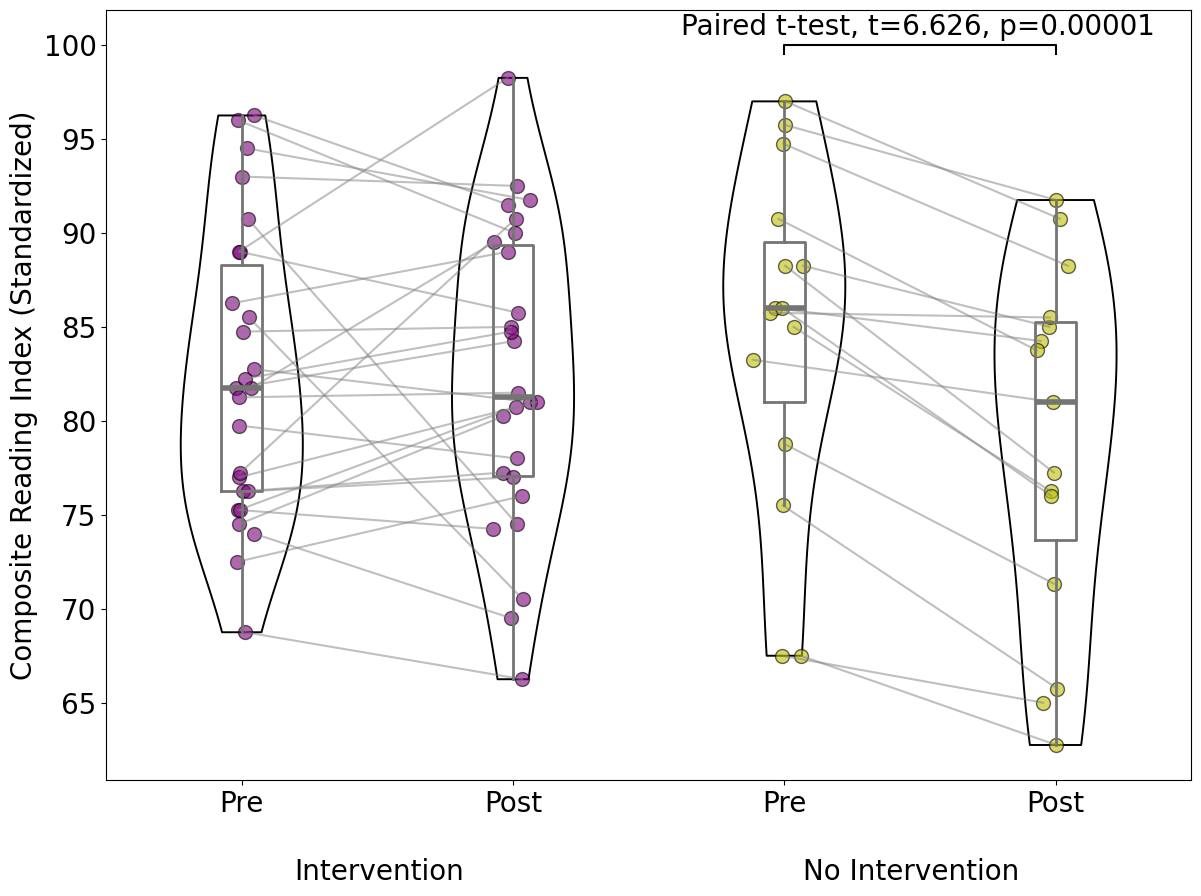

In [20]:
# Create figure/axes object
fig, ax = plt.subplots(figsize= (14, 10))

# Colors for plot
BG_WHITE = "#fbf9f4"
GREY_DARK = "#747473"
# Set background color
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Colors for participant data
COLOR_SCALE = ["purple", "purple", "y", "y"]

tick_len = 0.5 # For signifiance markers

# Horizontal positions for the violins. 
POSITIONS = [0, 1, 2, 3]

# Get reading data to plot for intervention and no intervention groups
times = ['pre', 'post']
score = "Composite_Score_ss"
scores_int = [df[df["Intervention"] == "Y"][f"{score}_{time}"].values for time in times]
scores_noint = [df[df["Intervention"] == "N"][f"{score}_{time}"].values for time in times]

# Define x position of dots with a jitter
jitter = 0.03
x_data_int = [np.array([i] * len(d)) for i, d in enumerate(scores_int)]
x_data_noint = [np.array([i+2] * len(d)) for i, d in enumerate(scores_noint)]
x_jittered_int = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data_int]
x_jittered_noint = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data_noint]

### Add intervention data

# Add violins
violins = ax.violinplot(
    scores_int, 
    positions=POSITIONS[0:2],
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)
# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor("BLACK")
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    
# Add boxplots
medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    scores_int,
    positions=POSITIONS[0:2], 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots
for x, y, color in zip(x_jittered_int, scores_int, COLOR_SCALE[0:2]):
    ax.scatter(x, y, s = 100, color=color, alpha=0.6, edgecolors='k')
# Add lines connecting the pre-post pairs
for i in range(np.shape(x_jittered_int)[1]):
    plt.plot([x_jittered_int[0][i], x_jittered_int[1][i]], [scores_int[0][i], scores_int[1][i]], color='gray', alpha=0.5)
    
### Add no intervention data
    
# Add violins
violins = ax.violinplot(
    scores_noint, 
    positions=POSITIONS[2:],
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)
# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor("BLACK")
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    
# Add boxplots
medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    scores_noint,
    positions=POSITIONS[2:], 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots
for x, y, color in zip(x_jittered_noint, scores_noint, COLOR_SCALE[2:]):
    ax.scatter(x, y, s = 100, color=color, alpha=0.6, edgecolors='k')
# Add lines connecting the pre-post pairs
for i in range(np.shape(x_jittered_noint)[1]):
    plt.plot([x_jittered_noint[0][i], x_jittered_noint[1][i]], [scores_noint[0][i], scores_noint[1][i]], color='gray', alpha=0.5)
    
### Add some labels and text to the plot
plt.ylabel('Composite Reading Index (Standardized)', fontsize=20)
plt.xticks(ticks=POSITIONS, labels=['Pre', 'Post', 'Pre', 'Post'], fontsize=20)
plt.yticks(fontsize=20)
txt="Intervention"
plt.figtext(.32, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=20)
txt="No Intervention"
plt.figtext(.7, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=20)

### Add some significance brackets
# For paired t-test
height = 100
ax.plot([2, 2, 3, 3], [height - tick_len, height, height, height - tick_len], c="black")
test = st.ttest_rel(scores_noint[0], scores_noint[1])
txt=f"Paired t-test, t={test.statistic:.3f}, p={test.pvalue:.5f}"
plt.figtext(.705, .855, txt, wrap=True, horizontalalignment='center', fontsize=20)

plt.savefig(f'figures/Composite_score_figure.png', bbox_inches='tight')
plt.show()

# Plot changes in wholebrain metrics (Figure S2)

### FA

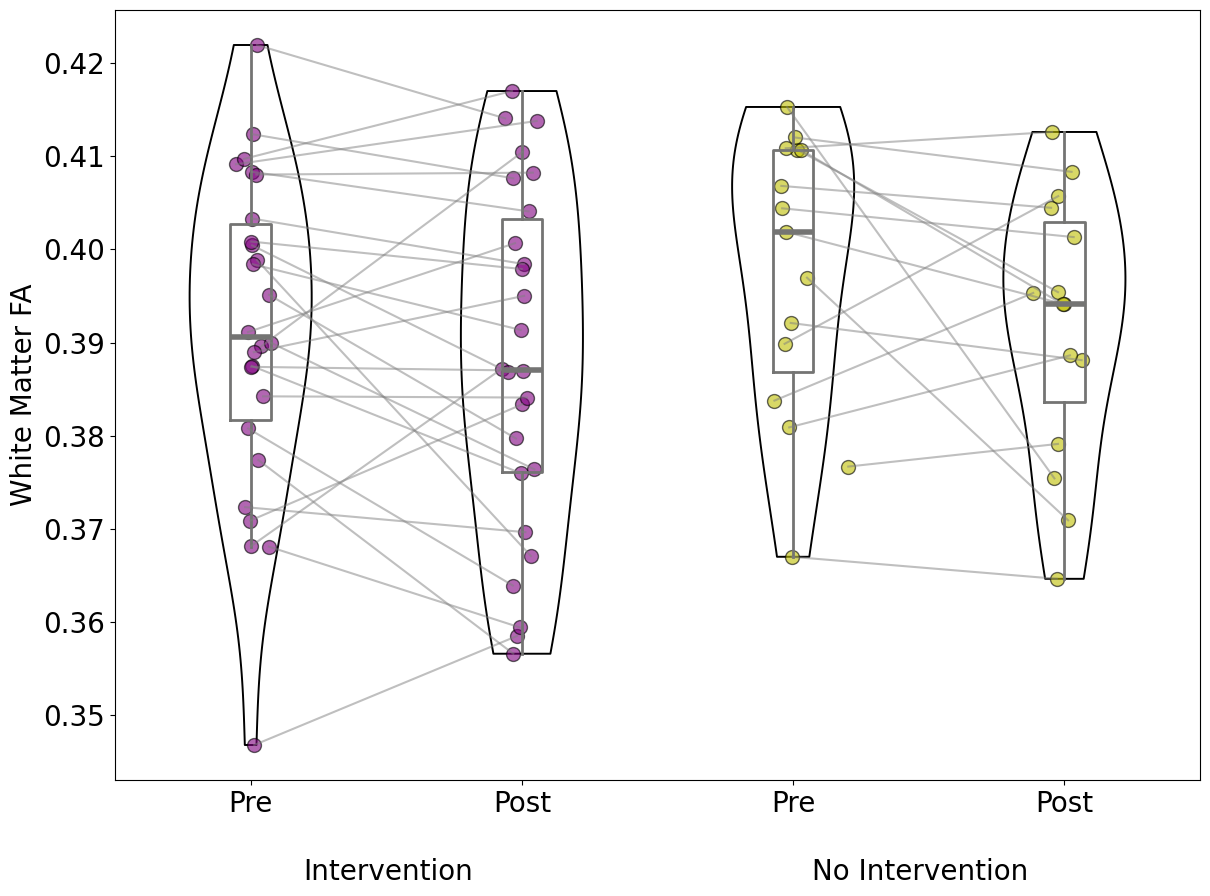

In [43]:
# Create figure/axes object
fig, ax = plt.subplots(figsize= (14, 10))

# Colors for plot
BG_WHITE = "#fbf9f4"
GREY_DARK = "#747473"
# Set background color
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Colors for participant data
COLOR_SCALE = ["purple", "purple", "y", "y"]

tick_len = 0.5 # For signifiance markers

# Horizontal positions for the violins. 
POSITIONS = [0, 1, 2, 3]

# Get reading data to plot for intervention and no intervention groups
times = ['pre', 'post']
score = "wholebrain_FA"
scores_int = [df[df["Intervention"] == "Y"][f"{score}_{time}"].values for time in times]
scores_noint = [df[df["Intervention"] == "N"][f"{score}_{time}"].values for time in times]

# Define x position of dots with a jitter
jitter = 0.03
x_data_int = [np.array([i] * len(d)) for i, d in enumerate(scores_int)]
x_data_noint = [np.array([i+2] * len(d)) for i, d in enumerate(scores_noint)]
x_jittered_int = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data_int]
x_jittered_noint = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data_noint]

### Add intervention data

# Add violins
violins = ax.violinplot(
    scores_int, 
    positions=POSITIONS[0:2],
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)
# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor("BLACK")
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    
# Add boxplots
medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    scores_int,
    positions=POSITIONS[0:2], 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots
for x, y, color in zip(x_jittered_int, scores_int, COLOR_SCALE[0:2]):
    ax.scatter(x, y, s = 100, color=color, alpha=0.6, edgecolors='k')
# Add lines connecting the pre-post pairs
for i in range(np.shape(x_jittered_int)[1]):
    plt.plot([x_jittered_int[0][i], x_jittered_int[1][i]], [scores_int[0][i], scores_int[1][i]], color='gray', alpha=0.5)
    
### Add no intervention data
    
# Add violins
violins = ax.violinplot(
    scores_noint, 
    positions=POSITIONS[2:],
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)
# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor("BLACK")
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    
# Add boxplots
medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    scores_noint,
    positions=POSITIONS[2:], 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots
for x, y, color in zip(x_jittered_noint, scores_noint, COLOR_SCALE[2:]):
    ax.scatter(x, y, s = 100, color=color, alpha=0.6, edgecolors='k')
# Add lines connecting the pre-post pairs
for i in range(np.shape(x_jittered_noint)[1]):
    plt.plot([x_jittered_noint[0][i], x_jittered_noint[1][i]], [scores_noint[0][i], scores_noint[1][i]], color='gray', alpha=0.5)
    
### Add some labels and text to the plot
plt.ylabel('White Matter FA', fontsize=20)
plt.xticks(ticks=POSITIONS, labels=['Pre', 'Post', 'Pre', 'Post'], fontsize=20)
plt.yticks(fontsize=20)
txt="Intervention"
plt.figtext(.32, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=20)
txt="No Intervention"
plt.figtext(.7, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=20)

plt.savefig(f'figures/FA_figure.png', bbox_inches='tight')
plt.show()

### MD

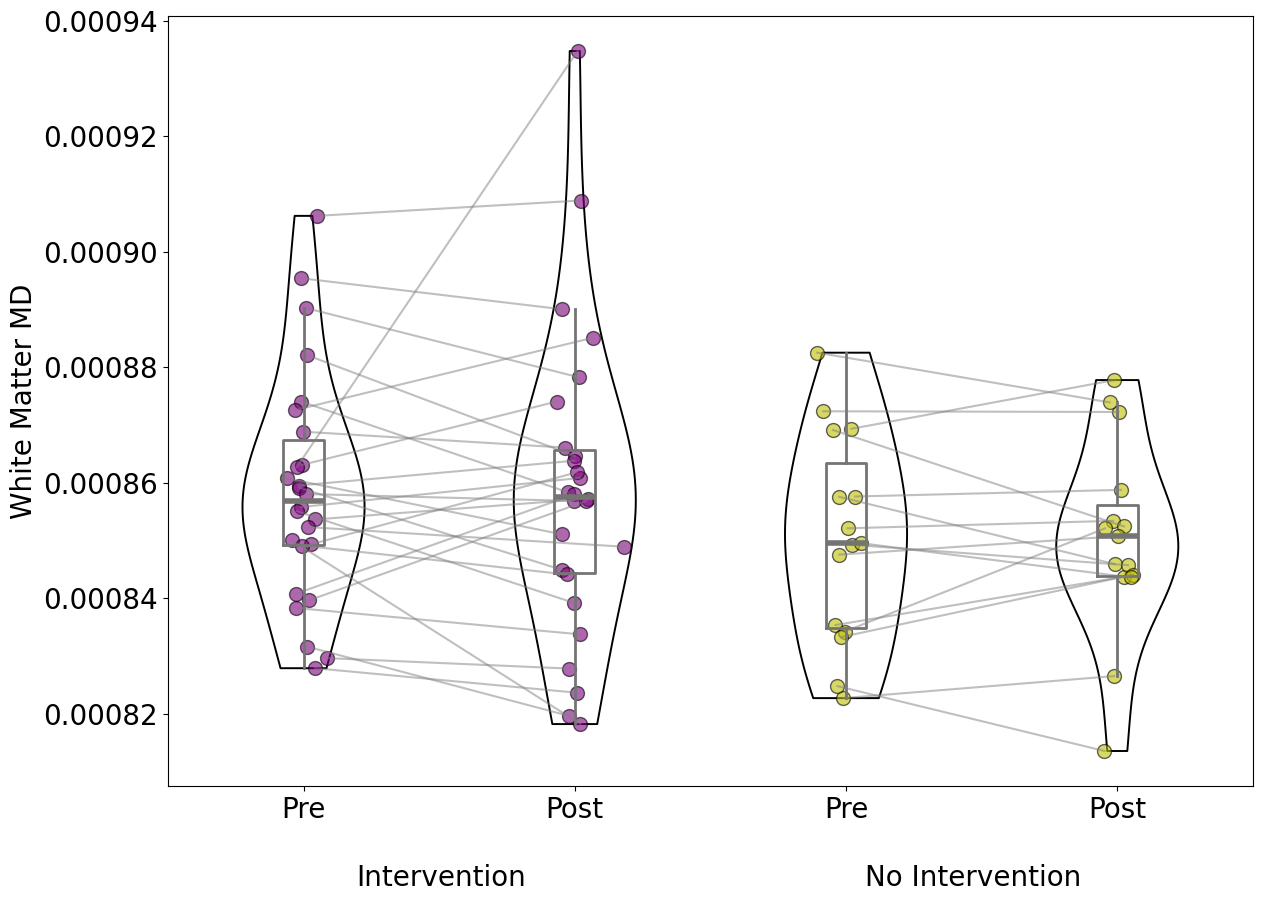

In [44]:
# Create figure/axes object
fig, ax = plt.subplots(figsize= (14, 10))

# Colors for plot
BG_WHITE = "#fbf9f4"
GREY_DARK = "#747473"
# Set background color
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Colors for participant data
COLOR_SCALE = ["purple", "purple", "y", "y"]

tick_len = 0.5 # For signifiance markers

# Horizontal positions for the violins. 
POSITIONS = [0, 1, 2, 3]

# Get reading data to plot for intervention and no intervention groups
times = ['pre', 'post']
score = "wholebrain_MD"
scores_int = [df[df["Intervention"] == "Y"][f"{score}_{time}"].values for time in times]
scores_noint = [df[df["Intervention"] == "N"][f"{score}_{time}"].values for time in times]

# Define x position of dots with a jitter
jitter = 0.03
x_data_int = [np.array([i] * len(d)) for i, d in enumerate(scores_int)]
x_data_noint = [np.array([i+2] * len(d)) for i, d in enumerate(scores_noint)]
x_jittered_int = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data_int]
x_jittered_noint = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data_noint]

### Add intervention data

# Add violins
violins = ax.violinplot(
    scores_int, 
    positions=POSITIONS[0:2],
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)
# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor("BLACK")
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    
# Add boxplots
medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    scores_int,
    positions=POSITIONS[0:2], 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots
for x, y, color in zip(x_jittered_int, scores_int, COLOR_SCALE[0:2]):
    ax.scatter(x, y, s = 100, color=color, alpha=0.6, edgecolors='k')
# Add lines connecting the pre-post pairs
for i in range(np.shape(x_jittered_int)[1]):
    plt.plot([x_jittered_int[0][i], x_jittered_int[1][i]], [scores_int[0][i], scores_int[1][i]], color='gray', alpha=0.5)
    
### Add no intervention data
    
# Add violins
violins = ax.violinplot(
    scores_noint, 
    positions=POSITIONS[2:],
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)
# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor("BLACK")
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    
# Add boxplots
medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    scores_noint,
    positions=POSITIONS[2:], 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots
for x, y, color in zip(x_jittered_noint, scores_noint, COLOR_SCALE[2:]):
    ax.scatter(x, y, s = 100, color=color, alpha=0.6, edgecolors='k')
# Add lines connecting the pre-post pairs
for i in range(np.shape(x_jittered_noint)[1]):
    plt.plot([x_jittered_noint[0][i], x_jittered_noint[1][i]], [scores_noint[0][i], scores_noint[1][i]], color='gray', alpha=0.5)
    
### Add some labels and text to the plot
plt.ylabel('White Matter MD', fontsize=20)
plt.xticks(ticks=POSITIONS, labels=['Pre', 'Post', 'Pre', 'Post'], fontsize=20)
plt.yticks(fontsize=20)
txt="Intervention"
plt.figtext(.32, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=20)
txt="No Intervention"
plt.figtext(.7, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=20)

plt.savefig(f'figures/MD_figure.png', bbox_inches='tight')
plt.show()